In [1]:
import pandas as pd
import os
from tqdm import tqdm
import seaborn as sns
import mne
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from scipy.stats import pearsonr
from sklearn.neighbors import NearestCentroid as NCC

In [2]:
try:
    all_filtered_epochs = np.load('all_epochs.npy')
except:
    print("No file found")

In [10]:
eeg_channels = ['Fp1', 'Fp2', 'AF7', 'AF3', 'AF4', 'AF8', 'F7', 'F5', 'F3',
    'F1', 'Fz', 'F2', 'F4', 'F6', 'F8', 'FT7', 'FC5', 'FC3', 'FC1', 'FCz',
    'FC2', 'FC4', 'FC6', 'FT8', 'T7', 'C5', 'C3', 'C1', 'Cz', 'C2', 'C4',
    'C6', 'T8', 'TP7', 'CP5', 'CP3', 'CP1', 'CPz', 'CP2', 'CP4', 'CP6',
    'TP8', 'P7', 'P5', 'P3', 'P1', 'Pz', 'P2', 'P4', 'P6', 'P8', 'PO7',
    'POz', 'P08', 'O1', 'O2']

all_labels = pd.read_csv('dataset/TrainLabels.csv').Prediction.values

In [11]:
X = []
features = [f"average {channel} voltage from {time_point * 5 - 200} to {time_point * 5 - 175} ms" for channel in eeg_channels for time_point in range(100, 130, 5)]

for id in tqdm(range(len(eeg_channels))):
    channel_data = [epoch[:, id] for epoch in all_filtered_epochs]
    channel_data = np.array(channel_data)
    for time_point in range(100, 130, 5):
        time_window_data = channel_data[:, time_point:time_point+5].mean(axis=1) # average voltage over 5 time points (25ms)
        X.append(time_window_data) # append the time window data to the list of all epochs in the session

X = np.array(X).T # Transpose to get shape (n_samples, n_features)
X_train, X_test, y_train, y_test = train_test_split(X, all_labels, test_size=0.2, random_state=42)

100%|██████████████████████████████████████████████████████████████████████████████████| 56/56 [00:02<00:00, 25.28it/s]


In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Step 1: Combine features and labels
df = pd.DataFrame(X)
df['label'] = all_labels

# Step 2: Separate majority and minority classes
class_0 = df[df['label'] == 0]
class_1 = df[df['label'] == 1]

# Step 3: Undersample class 1
class_1_downsampled = resample(class_1,
                               replace=False,
                               n_samples=len(class_0),
                               random_state=42)

# Step 4: Combine and shuffle
balanced_df = pd.concat([class_0, class_1_downsampled])
balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Step 5: Split into features and labels
X_balanced = balanced_df.drop('label', axis=1).values
y_balanced = balanced_df['label'].values

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

# Done!
print("Class distribution after balancing:", np.bincount(y_balanced))
print("Training set shape:", X_train.shape)
print("Test set shape:", X_test.shape)


Class distribution after balancing: [1590 1590]
Training set shape: (2544, 336)
Test set shape: (636, 336)


In [13]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Perform PCA to retain 95% of the variance
pca = PCA(n_components=0.95)  # This will retain enough components to explain 95% of the variance
X_train_pca = pca.fit_transform(X_train_scaled)

print(f"Number of components chosen by PCA: {pca.n_components_}")
print(f"Variance explained by the selected components: {sum(pca.explained_variance_ratio_)}")

Number of components chosen by PCA: 14
Variance explained by the selected components: 0.9529023574677751


LDA Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       335
           1       0.59      0.63      0.61       301

    accuracy                           0.62       636
   macro avg       0.62      0.62      0.62       636
weighted avg       0.62      0.62      0.62       636



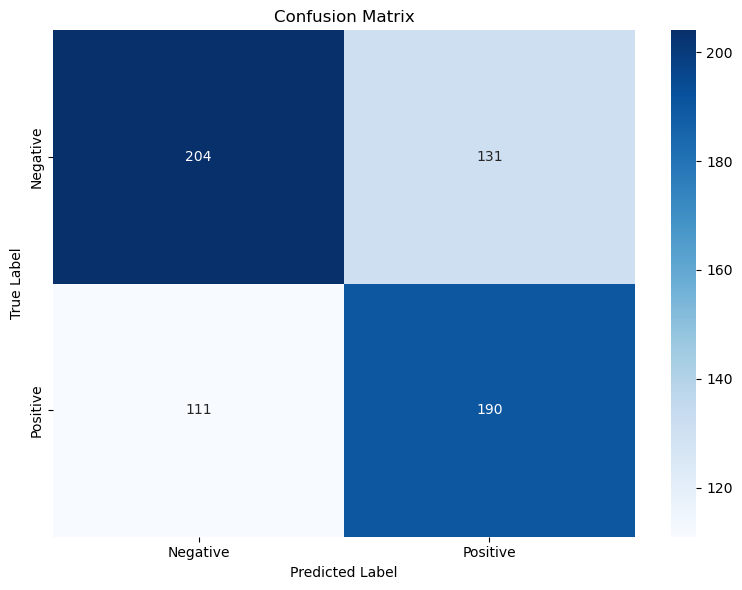

ROC AUC Score: 0.6201


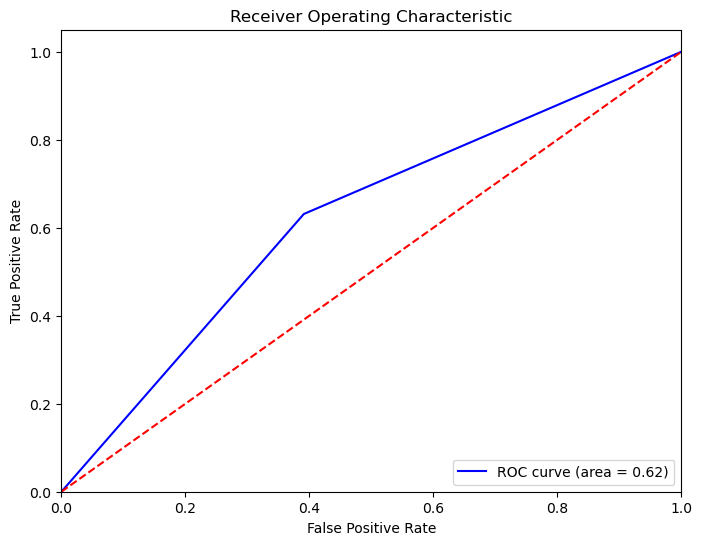

In [14]:
from sklearn.metrics import roc_curve

# Create an LDA model
lda = LDA()
lda.fit(X_train_pca, y_train)

X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)
y_pred_lda = lda.predict(X_test_pca)

# Print metrics
print("LDA Classification Report:")
print(classification_report(y_test, y_pred_lda))

# Create confusion matrix display
conf_matrix = confusion_matrix(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for LDA:
roc_auc_score_value = roc_auc_score(y_test, y_pred_lda)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.61      0.62       335
           1       0.57      0.57      0.57       301

    accuracy                           0.60       636
   macro avg       0.59      0.59      0.59       636
weighted avg       0.60      0.60      0.60       636



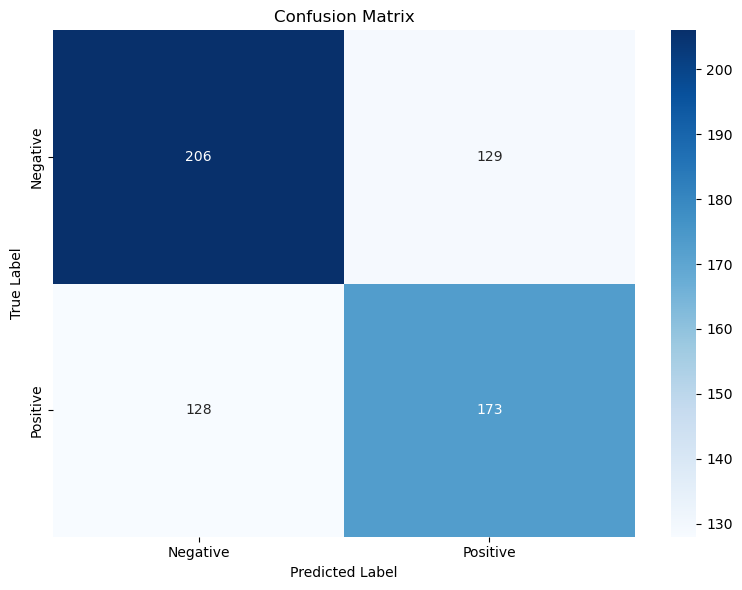

ROC AUC Score: 0.5948


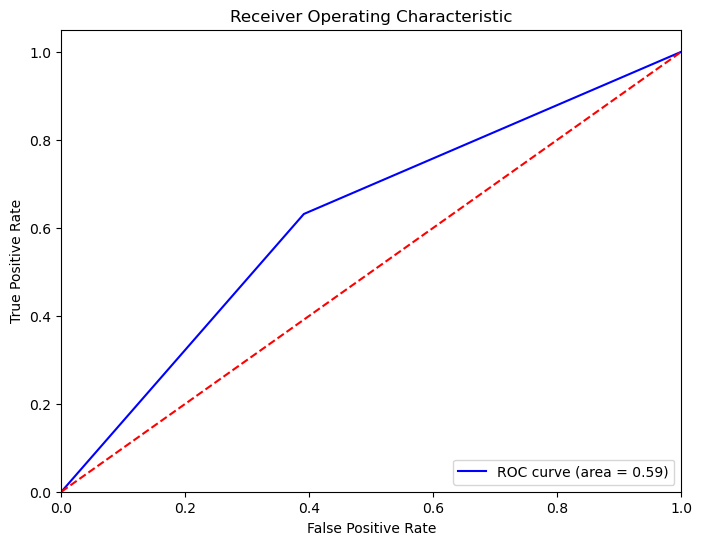

In [15]:
ncc = NCC()
ncc.fit(X_train_pca, y_train)
y_pred_lr = ncc.predict(X_test_pca)

print("Classification Report:")
print(classification_report(y_test, y_pred_lr))

conf_matrix_ncc = confusion_matrix(y_test, y_pred_lr)
conf_matrix = confusion_matrix(y_test, y_pred_lr)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC for NCC:
roc_auc_score_value = roc_auc_score(y_test, y_pred_lr)
print(f"ROC AUC Score: {roc_auc_score_value:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_lda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc_score_value)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

Regularized LDA (R-LDA) Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.60      0.62       335
           1       0.59      0.65      0.62       301

    accuracy                           0.62       636
   macro avg       0.62      0.62      0.62       636
weighted avg       0.62      0.62      0.62       636



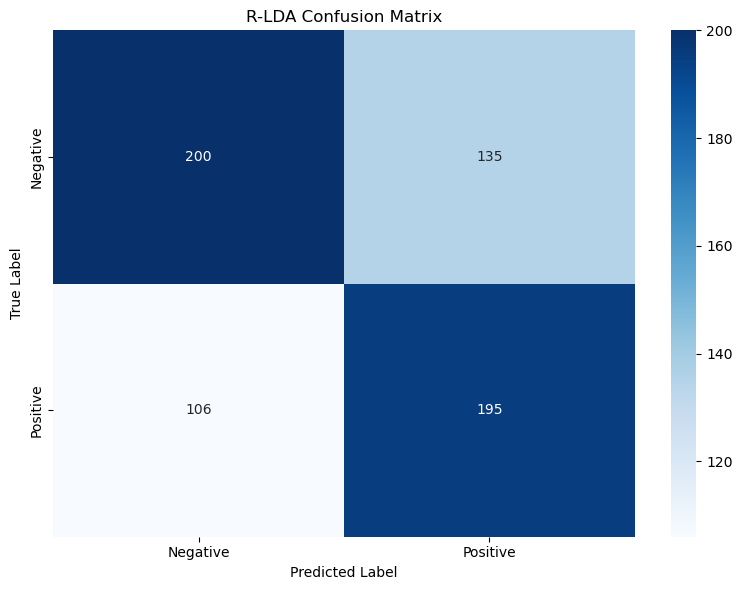

R-LDA ROC AUC Score: 0.6224


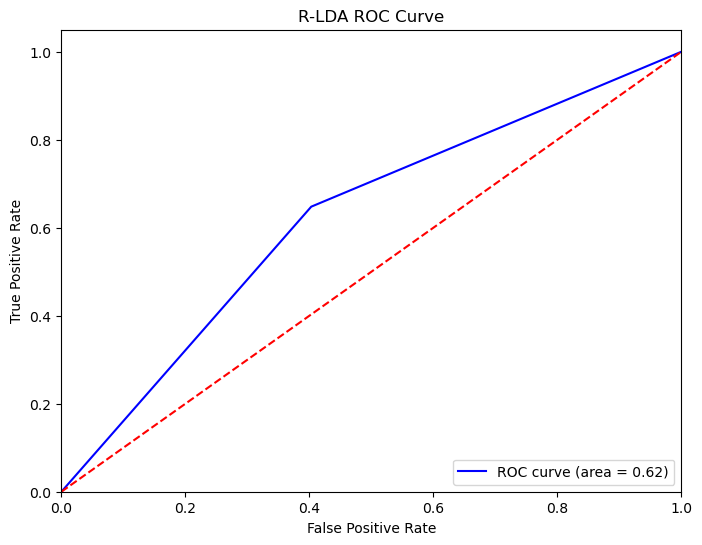

In [16]:
# Create and train LDA with shrinkage (real R-LDA)
rlda = LDA(solver='lsqr', shrinkage=0.5)  # 'auto' lets sklearn choose optimal shrinkage via Ledoit-Wolf
rlda.fit(X_train_pca, y_train)

# Predict
y_pred_rlda = rlda.predict(X_test_pca)

# Classification report
print("Regularized LDA (R-LDA) Classification Report:")
print(classification_report(y_test, y_pred_rlda))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_rlda)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('R-LDA Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_rlda)
print(f"R-LDA ROC AUC Score: {roc_auc:.4f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_rlda)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('R-LDA ROC Curve')
plt.legend(loc='lower right')
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.61      0.64       335
           1       0.61      0.66      0.63       301

    accuracy                           0.64       636
   macro avg       0.64      0.64      0.64       636
weighted avg       0.64      0.64      0.64       636



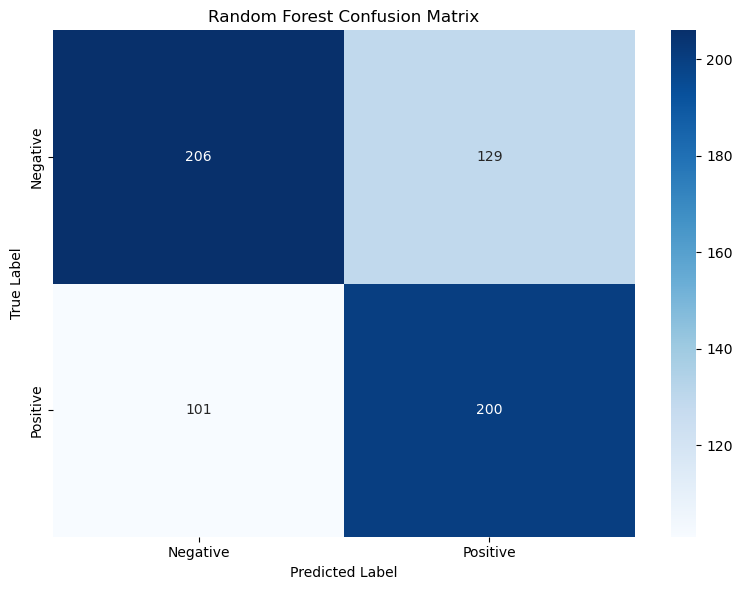

Random Forest ROC AUC Score: 0.6397


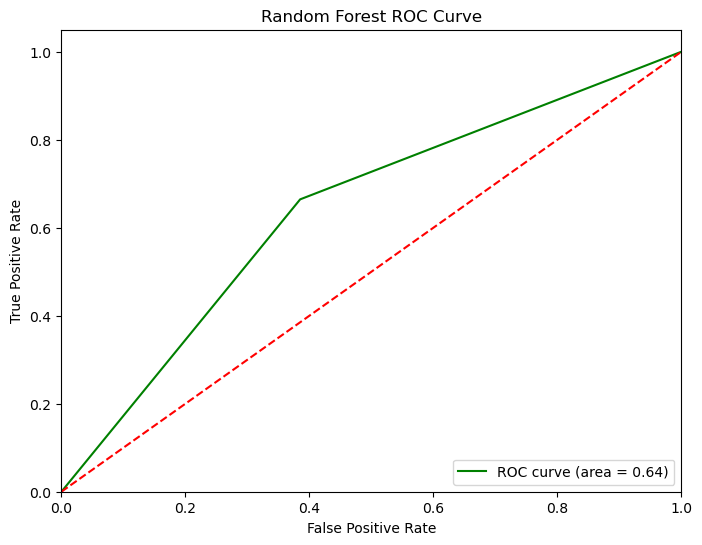

In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns

# Train Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_pca, y_train)

# Predict
y_pred_rf = rf.predict(X_test_pca)

# Classification Report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))

# Confusion Matrix
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.show()

# ROC AUC Score
roc_auc_rf = roc_auc_score(y_test, y_pred_rf)
print(f"Random Forest ROC AUC Score: {roc_auc_rf:.4f}")

# ROC Curve
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
plt.figure(figsize=(8, 6))
plt.plot(fpr_rf, tpr_rf, color='green', label='ROC curve (area = %0.2f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest ROC Curve')
plt.legend(loc='lower right')
plt.show()